In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [2]:
ls_df = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Combined_GA_VA/GAVA_LANDSAT.csv')
elev_df = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Combined_GA_VA/gava_dm_gm_elev.csv')

In [3]:
ls_df['Year'] = ls_df['LS_year']

In [69]:
df0 = pd.merge(ls_df, elev_df, on = ['Plant_Biomass', 'Latitude', 'Longitude', 'Year'], how = 'left',
              suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

df0


# Apply z-star transformation
df0['z_star'] = np.where(
    df0['Latitude'] >= 35,
    (df0['elevation'] - (-0.106)) / (0.569 - (-0.106)),  # formula for >= 35
    (df0['elevation'] - (-0.071)) / (0.569 - (-0.071))   # formula for < 35
)

In [70]:
##Add site - be careful if adding MA in the future
df0['Site'] = np.where(
    df0['Latitude'] >= 35,
    ('VA'),  # formula for >= 35
    ('GA'   # formula for < 35
))

In [65]:
##EXPORT
out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'gava_final.csv')
# df0.to_csv(out_csv, index = False)

In [79]:
# for col in df0.columns:
#     print(col)

# df0 = df0[df0['Plant_Biomass'] <= 2500]


In [83]:
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime

yargs=df0['Plant_Biomass'] 

# xargs=df0.loc[:, ~df0.columns.isin(['Plant_Biomass', 'Latitude', 'Longitude', 'Unnamed: 0', 
#                           'Sampling_year', 'LS_year', 'Site', 'Year', 'index', 'elevation'])]


xargs = df0[['z_star','Percent_flooding','slope', 'dayl_Max', 'dayl_Min', 'nd_swir2_nir_median_08_10',
             'nd_swir2_nir_median_05_10','srad_peak','nd_swir2_nir_mean_05_10', 'nd_r_g_max_05_10', 'nd_r_g_sum_08_10',
             'nd_swir2_nir_mean_08_10', 'spei14d', 'nd_swir2_nir_sum_08_10', 'nd_r_g_max_08_10', 'nd_swir2_nir_mean_01_12', 
             'nd_swir2_nir_min_05_10', 'vp', 'dayl_daymMarMay', 'nd_swir2_nir_min_01_12', 'nd_swir2_nir_min_01_12', 
             'thermal_band_celsius_mean_01_12'
            ]]

##dayl_Max and Min are MayOct (growing season) values
##speil14d is entire year gridmet


##GA MODEL PREDICTORS BELOW
# xargs = df0[['nd_swir2_nir_median_05_10','z_star','nd_swir2_nir_mean_05_10', 'Percent_flooding','srad_peak','evi_mean_08_10',
#             'evi_max_05_10','nd_g_b_mean_01_12','evi_max_01_12','nd_swir2_nir_median_08_10','nd_swir2_r_min_05_10',
#             'evi_mean_01_12','nd_g_b_median_01_12','Blue_band_max_05_10','nd_swir2_nir_median_01_12',
#             'Red_band_max_05_10','dayl_daymMarMay','eddi2y','nd_swir2_nir_min_05_10','savi_mean_01_12',
#             'slope']] #TOOK ELEV OUT, ADDED Z_STAR

##Removed:
''''elevation
                ''' 

size_x = 0.2
seed = 3
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test


'''LOG transform the river discharge data, and also calculate z scores'''

'LOG transform the river discharge data, and also calculate z scores'

In [84]:
#Pipeline:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics

# #Hyperparameters tuned later
# pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=300, 
#                                                                                 min_samples_split=5, 
#                                                                                 min_samples_leaf=2,
#                                                                                 max_depth=None, random_state=seed))])

pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=1000, 
                                                                                min_samples_split=5, 
                                                                                min_samples_leaf=1,
                                                                                max_depth=200, random_state=seed))])
'''
CodeEditor version:
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=1000, 
                                                                                min_samples_split=5, 
                                                                                min_samples_leaf=1,
                                                                                max_depth=200, random_state=seed))])
'''

# ##DEFAULTS:
# pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, 
#                                                                                 min_samples_split=2, 
#                                                                                 min_samples_leaf=1,
#                                                                                 max_depth=None, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

# Mean
print('MEAN BASELINE:')
y_pred_mean = [np.mean(yargs_train)] * len(yargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred_mean)))

# NDVI
print('NDVI BASELINE: around 0.2 r sq, RMSE 650')

Mean Absolute Error: 275.5834323255459
Mean Squared Error: 157349.03776795854
Root Mean Squared Error: 396.6724565280006
The r squared is: 0.5523639088526284
0.5523639088526284
testing r2 is: 0.5523639088526284
training r2 is: 0.8896662906567624
NRMSE is: 0.11393683449259993
MEAN BASELINE:
Mean Absolute Error: 426.8234272846959
Root Mean Squared Error: 593.6899140251988
NDVI BASELINE: around 0.2 r sq, RMSE 650


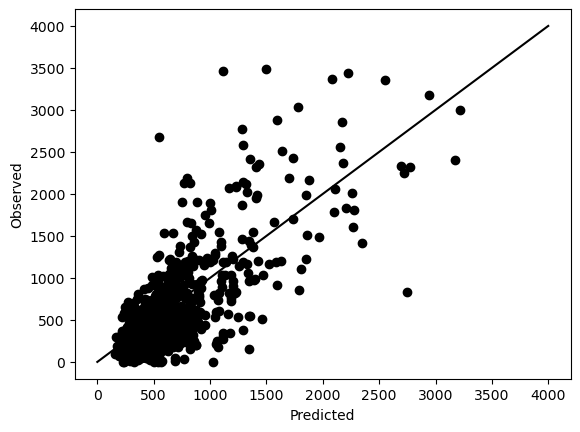

test data correlation coefficient is: 0.7448370340984514
train data correlation coefficient is: 0.9497602901436047


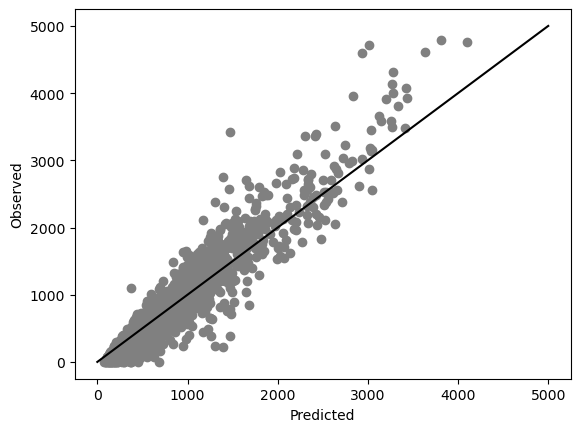

In [85]:
plt.scatter(y_pred, yargs_test, color = 'black') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 4000], [0, 4000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(yargs_test, y_pred)[0, 1]))

train_pred = pipe.predict(xargs_train) ##Not sure if this is the right thing to do here
plt.scatter(train_pred, yargs_train, color = 'gray')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 5000], [0, 5000], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(train_pred, yargs_train)[0, 1]))

In [53]:
##With sites colored:
import matplotlib.pyplot as plt

# Split predictors and response as before
sites = df0['Site']   # <-- column to color points by

size_x = 0.2
seed = 3

weights = np.where(sites_train == "VA", 6, 1.0)  # 6x weight for VA - reflects ratio of GA to VA points

x_train, x_test, y_train, y_test, sites_train, sites_test = train_test_split(
    xargs, yargs, sites, test_size=size_x, random_state=seed
)

pipe.fit(x_train, y_train, forest__sample_weight=weights)
y_pred = pipe.predict(x_test)



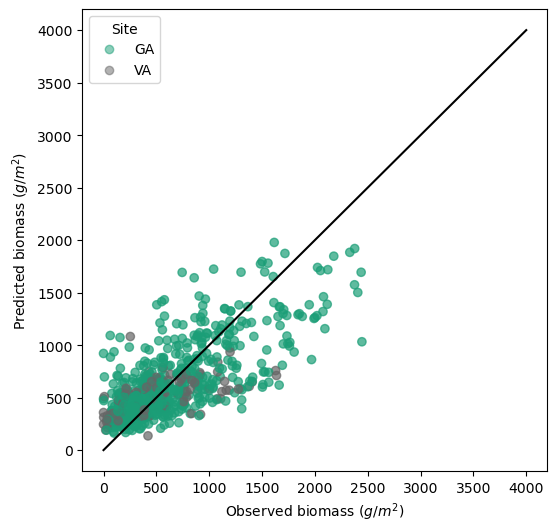

In [54]:
# --- Plot ---
# Map sites to numeric codes
site_codes = sites_test.astype('category').cat.codes

plt.figure(figsize=(6,6))
scatter = plt.scatter(x = y_test, y = y_pred, c=site_codes, cmap='Dark2', alpha=0.7)

plt.xlabel("Observed biomass ($g$/$m^2$)")
plt.ylabel("Predicted biomass ($g$/$m^2$)")
plt.plot([0, 4000], [0, 4000], 'k-')

# Add legend with original labels
handles, labels = scatter.legend_elements(prop="colors", alpha=0.5)
plt.legend(handles, sites_test.astype('category').cat.categories, title="Site")

plt.show()

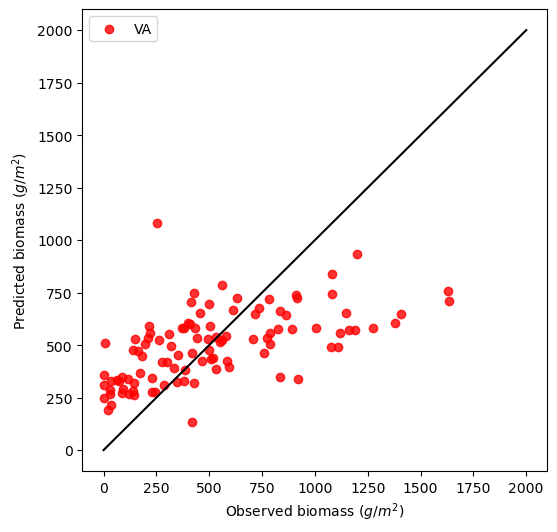

In [55]:
mask = sites_test == "VA"

plt.figure(figsize=(6,6))
plt.scatter(x = y_test[mask], y = y_pred[mask], color="red", alpha=0.8, label="VA")

plt.xlabel("Observed biomass ($g$/$m^2$)")
plt.ylabel("Predicted biomass ($g$/$m^2$)")
plt.plot([0, 2000], [0, 2000], 'k-')
plt.legend()
plt.show()


In [56]:
##R2 for just VA points

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Boolean mask for VA rows
mask = sites_test == "VA"

# Subset to VA points
y_pred_va = y_pred[mask]
y_test_va = y_test[mask]

# Metrics
r2_va = r2_score(y_test_va, y_pred_va)
rmse_va = np.sqrt(mean_squared_error(y_test_va, y_pred_va))

print(f"VA R²: {r2_va:.3f}")
print(f"VA RMSE: {rmse_va:.3f}")

VA R²: 0.315
VA RMSE: 321.782


In [75]:
##k-fold cross validation; random forest

#Predictors below are based on feature selection - most important variables

predictors = xargs

targets = yargs

from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import KFold, cross_validate

X, y = predictors, targets
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True)

model = pipe
scoring=('r2', 'neg_root_mean_squared_error')

cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)
cv_results

{'fit_time': array([41.06513047, 41.59971595, 40.9001379 , 41.64467335, 41.47999334,
        42.1649847 , 43.10149074, 47.73814416, 44.02401209, 43.04862523]),
 'score_time': array([0.08577323, 0.08778787, 0.08776212, 0.08776689, 0.08976221,
        0.08776093, 0.09474897, 0.10671711, 0.09676957, 0.08974051]),
 'test_r2': array([0.51066835, 0.58194185, 0.50386303, 0.52264462, 0.63671599,
        0.52468355, 0.62475771, 0.54698119, 0.63900908, 0.60795214]),
 'test_neg_root_mean_squared_error': array([-392.12194466, -400.32409545, -450.89412314, -407.52442674,
        -382.97332937, -382.71955193, -372.73027363, -455.0227121 ,
        -393.00515399, -364.01428549])}

In [76]:
#Feature importance and average RMSE
x = pd.DataFrame(cv_results)
print(x['test_r2'].mean())
print(x['test_neg_root_mean_squared_error'].mean())
print('NRMSE is: ' + str(x['test_neg_root_mean_squared_error'].mean()/np.ptp(yargs_test)))

0.5699217496380298
-400.13298965031584
NRMSE is: -0.11493080869757617


In [77]:
##Feature selection
import time
import numpy as np

feature_importances = pipe.named_steps['forest'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': xargs.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(21))  # Keep the top 20 most important features
xx = feature_importance_df.head(21)

# with(pd.set_option('display.max_rows', None) print(xx))

feature_importance_df

                            Feature  Importance
0                            z_star    0.150836
1                  Percent_flooding    0.140335
2                             slope    0.109366
3                          dayl_Max    0.048838
4                          dayl_Min    0.046426
10                 nd_r_g_sum_08_10    0.042634
5         nd_swir2_nir_median_08_10    0.041743
12                          spei14d    0.039847
21  thermal_band_celsius_mean_01_12    0.038512
7                         srad_peak    0.038238
9                  nd_r_g_max_05_10    0.037729
6         nd_swir2_nir_median_05_10    0.037529
13           nd_swir2_nir_sum_08_10    0.036650
17                               vp    0.032764
15          nd_swir2_nir_mean_01_12    0.031853
14                 nd_r_g_max_08_10    0.028476
11          nd_swir2_nir_mean_08_10    0.024911
8           nd_swir2_nir_mean_05_10    0.021411
16           nd_swir2_nir_min_05_10    0.016695
20           nd_swir2_nir_min_01_12    0

,Feature,Importance
0,z_star,0.150836
1,Percent_flooding,0.140335
2,slope,0.109366
3,dayl_Max,0.048838
4,dayl_Min,0.046426
10,nd_r_g_sum_08_10,0.042634
5,nd_swir2_nir_median_08_10,0.041743
12,spei14d,0.039847
21,thermal_band_celsius_mean_01_12,0.038512
7,srad_peak,0.038238


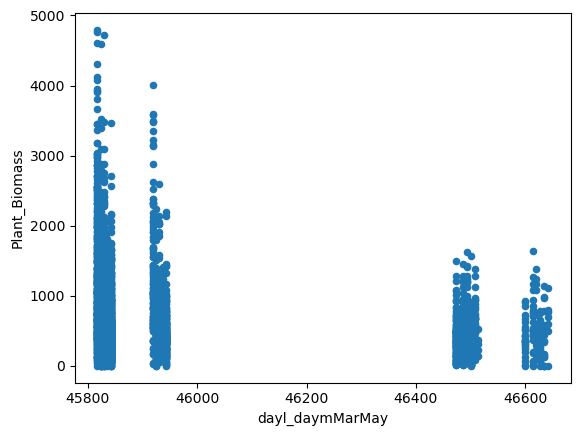

In [34]:
g = df0.plot(kind = 'scatter', x = 'dayl_daymMarMay', y = 'Plant_Biomass')

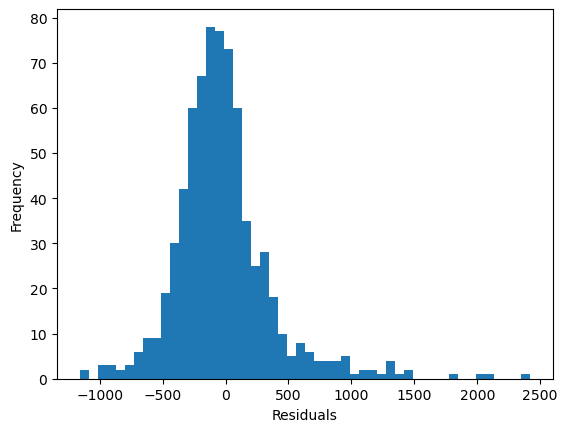

In [35]:
import matplotlib.pyplot as plt
residuals = yargs_test - y_pred
plt.hist(residuals, bins=50)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [34]:
# from sklearn.model_selection import RandomizedSearchCV

# param_grid = {
#     'forest__n_estimators': [50, 100, 200, 300, 500, 1000],
#     'forest__max_depth': [10, 20, 30, None],
#     'forest__min_samples_split': [2, 5, 10],
#     'forest__min_samples_leaf': [1, 2, 4]
# }

# rf_search = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=50, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=seed)
# rf_search.fit(xargs_train, yargs_train)

# print("Best Params:", rf_search.best_params_)
# pipe = rf_search.best_estimator_

Best Params: {'forest__n_estimators': 300, 'forest__min_samples_split': 5, 'forest__min_samples_leaf': 2, 'forest__max_depth': None}


C:\ProgramData\Anaconda3\envs\geeml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\Anaconda3\envs\geeml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\Anaconda3\envs\geeml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\Anaconda3\envs\geeml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

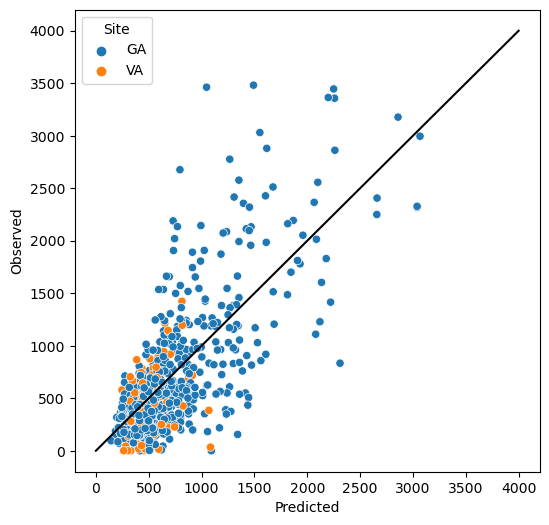

C:\ProgramData\Anaconda3\envs\geeml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\Anaconda3\envs\geeml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


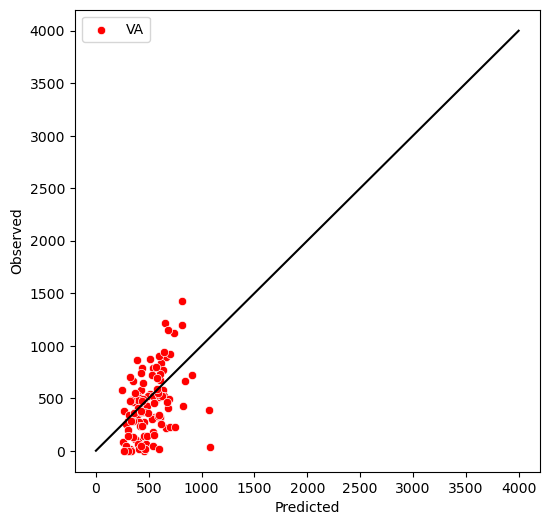

In [32]:
import seaborn as sns

test_df = pd.DataFrame({
    'Predicted': y_pred,
    'Observed': y_test,
    'Site': sites_test
})

plt.figure(figsize=(6,6))
sns.scatterplot(data=test_df, x='Predicted', y='Observed', hue='Site', palette='tab10')

plt.plot([0, 4000], [0, 4000], 'k-')
plt.show()


test_df = pd.DataFrame({
    'Predicted': y_pred,
    'Observed': y_test,
    'Site': sites_test
})

va_df = test_df[test_df['Site'] == "VA"]

plt.figure(figsize=(6,6))
sns.scatterplot(data=va_df, x='Predicted', y='Observed', color="red", label="VA")

plt.plot([0, 4000], [0, 4000], 'k-')
plt.legend()
plt.show()
